In [26]:
def discretizar_y(array, num_points):
    if num_points == 1:
        print(" Minimo de particiones: 2")
        return np.array([])
    window = (np.abs(np.min(array)) + np.abs(np.max(array)))/(num_points - 1)
    discretizador = [np.min(array)+window*(i) for i in range(num_points)]
    if discretizador[len(discretizador)-1] != np.max(array):
        discretizador[len(discretizador)-1] = np.max(array)
    array_discreto = []
    for i,valor in enumerate(array):
        array_discreto.append(min(discretizador, key=lambda x: abs(x - valor)))

    return array_discreto

def symbolic_sequence_f(orbit, num_partitions):

    def split_partitions(num_partitions):
        symbols = list(range(1, num_partitions + 1))
        partitions = []

        partition_points = np.linspace(np.min(orbit), np.max(orbit), num_partitions + 1)

        for i in range(num_partitions):
            start = partition_points[i]
            end = partition_points[i + 1]
            symbol = symbols[i]
            partitions.append((start, end, symbol))
        return partitions


    sequence = []
    partitions = split_partitions(num_partitions)

    for x in orbit:
        
        # Determinar en qué partición cae x y agregar el símbolo correspondiente
        for (start, end, symbol) in partitions:
            if start <= x < end:
                sequence.append(symbol)
                break

    return sequence

def discretizar_x(array_y, num_points):
    if num_points == 1:
        print(" Minimo de particiones: 2")
        return np.array([])
    array_x = range(int(len(array_y)))
    window = (len(array_x))/(num_points - 1)
    x_discreto = [int(window*(i)) for i in range(num_points)]
    array_discreto = []
    for i in x_discreto[0:len(x_discreto)-1]:
        array_discreto.append(array_y[i])
    array_discreto.append(array_y[len(array_x)-1])

    return array_discreto

In [53]:
def J_bivariante(X,Y,fases):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    ff1 = np.angle(np.fft.rfft(X))[:fases]
    ff2 = np.angle(np.fft.rfft(Y))[:fases]
    plt.plot(ff1, ',')
    plt.show()
    plt.plot(ff2, ',')
    plt.show()
    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2=cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos=[]
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        v1_norm=v1/np.linalg.norm(v1)
        v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)
    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J

In [3]:
import numpy as np

def lyapunov_exponent_from_henon_orbit(xs, ys, a, b):
    # Vectores de perturbación iniciales
    v1, v2 = np.array([1.0, 0.0]), np.array([0.0, 1.0])  

    sum_ln1, sum_ln2 = 0.0, 0.0  # Sumas para los exponentes de Lyapunov
    n = len(xs)
    
    for i in range(n):
        # Derivadas parciales del mapa de Henon
        dfdx = -2 * a * xs[i]
        dfdy = 1
        dgdx = b
        dgdy = 0
        
        # Matriz jacobiana del mapa de Henon
        J = np.array([[dfdx, dfdy],
                      [dgdx, dgdy]])
        
        # Aplicar la matriz jacobiana a los vectores de perturbación
        v1 = np.dot(J, v1)
        v2 = np.dot(J, v2)

        # Gram-Schmidt ortogonalización
        v1_norm = np.linalg.norm(v1)
        v1 = v1 / v1_norm
        
        v2_proj = np.dot(v1, v2) * v1  # Proyección de v2 sobre v1
        v2 = v2 - v2_proj
        v2_norm = np.linalg.norm(v2)
        v2 = v2 / v2_norm
        
        # Actualizar las sumas de los logaritmos de los cocientes
        sum_ln1 += np.log(v1_norm)
        sum_ln2 += np.log(v2_norm)

    # Cálculo de los exponentes de Lyapunov
    le1 = sum_ln1 / n
    le2 = sum_ln2 / n

    return max(le1, le2)

In [30]:
def brownian_bridge(t0, tT, x0, xT, n_steps):
    t = np.linspace(t0, tT, n_steps)
    #Generar movimiento browniano con media cero
    W = np.random.normal(0, np.sqrt(t[1] - t[0]), size=n_steps-1)
    W = np.insert(np.cumsum(W), 0, 0)  # Inserta W(0) = 0 y suma acumulativa
    # Interpolación del Brownian Bridge
    X = x0 + (t - t0) / (tT - t0) * (xT - x0) + W - (t - t0) / (tT - t0) * W[-1]
    return t, X

def interpolador_estocastico(s_0_discreto, n_steps):
    t_list, X_list = [], []
    for i in range(len(s_0_discreto)- 1):
        t0 = i
        tT = i+1
        x0 = s_0_discreto[i]
        xT = s_0_discreto[i+1]
        t, X = brownian_bridge(t0, tT, x0, xT, n_steps)
        t_list = np.concatenate((t_list, t))
        X_list = np.concatenate((X_list, X))
    return X_list

Correlación de Spearman: 0.8550095871260047


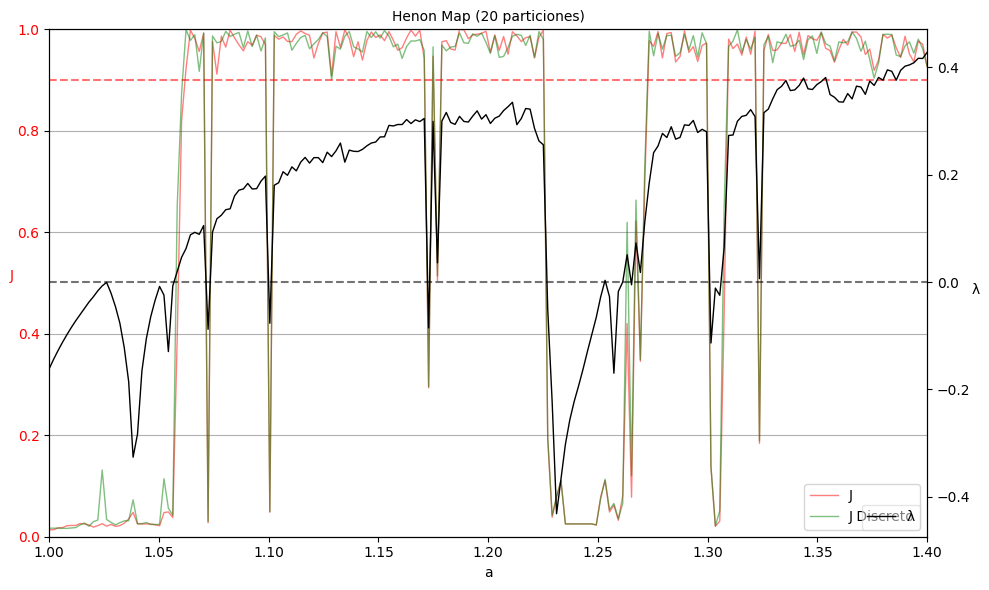

In [52]:
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

def henon_map(a, b, n):
    xs = np.zeros(n)
    ys = np.zeros(n)
    
    xs[0] = 0.1
    ys[0] = 0.1
    
    for i in range(1, n):
        xs[i] = 1 - a * xs[i-1]**2 + ys[i-1]
        ys[i] = b * xs[i-1]
    
    return xs, ys

partitions = 20

lyapunov = [] 
Js, Js_discreto = [],[]
a_array = np.linspace(1,1.4, 200)
for i, a in enumerate(a_array): 
    xs, ys = henon_map(a, 0.3, 2000)
    # xs_discreto = symbolic_sequence_f(xs,partitions)
    # ys_discreto = symbolic_sequence_f(ys,partitions)
    xs_discreto = discretizar_y(xs, partitions)
    ys_discreto = discretizar_y(ys, partitions)
    lyapunov_exponent = lyapunov_exponent_from_henon_orbit(xs, ys, a, 0.3)        
    lyapunov.append(lyapunov_exponent)
    J = J_bivariante(xs,ys,len(xs))
    J_discreto = J_bivariante(xs_discreto,ys_discreto,len(xs_discreto))
    Js.append(J)
    Js_discreto.append(J_discreto)

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(a_array, Js, color = 'red',linewidth=1, alpha = 0.5, label = 'J')
ax1.plot(a_array, Js_discreto, color = 'green',linewidth=1, alpha = 0.5, label = 'J Discreto')
ax1.set_ylabel('J', color='r', rotation = 360)
ax1.set_ylim(0,1) 
ax1.axhline(y=0.9, color='red', linestyle='--', alpha = 0.55)
ax1.tick_params(axis='y', labelcolor='r')
ax1.set_xlabel('a')
plt.grid(axis='y')
ax1.legend()

ax2 = ax1.twinx()
ax2.axhline(y=0, color='black', linestyle='--', alpha = 0.55)
ax2.plot(a_array, lyapunov,'black',linewidth= 1, label = 'λ')
ax2.legend(loc='lower right',framealpha=0.5)
ax2.set_ylabel('λ', rotation = 360)
plt.title(f'Henon Map ({partitions} particiones)', fontsize = 10)
ax2.set_xlim(1, 1.4)
plt.tight_layout()

correlacion, p_valor = spearmanr(Js, Js_discreto)

print(f'Correlación de Spearman: {correlacion}') # Correlación de Spearman: 0.8550095871260047



In [61]:
import numpy as np

def add_white_noise(data, snr):
    """
    Superpone ruido blanco a una serie de datos en función de la relación señal-ruido (SNR).
    
    Args:
    data (np.array): Serie de datos original.
    snr (float): Relación señal-ruido deseada (SNR) en dB.
    
    Returns:
    np.array: Serie de datos con ruido agregado.
    """
    # Calcular la potencia de la señal
    signal_power = np.mean(data ** 2)
    
    # Convertir SNR de dB a una razón
    snr_linear = 10 ** (snr / 10)
    
    # Calcular la potencia del ruido
    noise_power = signal_power / snr_linear
    
    # Generar ruido blanco con la potencia calculada
    noise = np.random.normal(0, np.sqrt(noise_power), data.shape)
    
    # Superponer el ruido a la señal
    noisy_data = data + noise
    
    return noisy_data


In [82]:
import numpy as np

def lorenz_system(x0, y0, z0, sigma=10, rho=1005, beta=8/3, dt=0.001, steps=10000):
    """
    Simula el sistema de Lorenz usando el método de Runge-Kutta de cuarto orden.
    
    Args:
    x0, y0, z0 (float): Condiciones iniciales para x, y, z.
    sigma, rho, beta (float): Parámetros del sistema de Lorenz.
    dt (float): Tamaño del paso de tiempo.
    steps (int): Número de pasos de simulación.
    
    Returns:
    tuple: Arrays de x, y, y z con las trayectorias del sistema de Lorenz.
    """
    # Inicializar arrays
    x = np.empty(steps)
    y = np.empty(steps)
    z = np.empty(steps)
    
    # Condiciones iniciales
    x[0], y[0], z[0] = x0, y0, z0
    
    # Integración de Runge-Kutta de cuarto orden
    for i in range(1, steps):
        # Definir las funciones derivadas
        dx = lambda x, y: sigma * (y - x)
        dy = lambda x, y, z: x * (rho - z) - y
        dz = lambda x, y, z: x * y - beta * z

        # Calcular los k para Runge-Kutta
        kx1 = dx(x[i-1], y[i-1]) * dt
        ky1 = dy(x[i-1], y[i-1], z[i-1]) * dt
        kz1 = dz(x[i-1], y[i-1], z[i-1]) * dt
        
        kx2 = dx(x[i-1] + 0.5 * kx1, y[i-1] + 0.5 * ky1) * dt
        ky2 = dy(x[i-1] + 0.5 * kx1, y[i-1] + 0.5 * ky1, z[i-1] + 0.5 * kz1) * dt
        kz2 = dz(x[i-1] + 0.5 * kx1, y[i-1] + 0.5 * ky1, z[i-1] + 0.5 * kz1) * dt
        
        kx3 = dx(x[i-1] + 0.5 * kx2, y[i-1] + 0.5 * ky2) * dt
        ky3 = dy(x[i-1] + 0.5 * kx2, y[i-1] + 0.5 * ky2, z[i-1] + 0.5 * kz2) * dt
        kz3 = dz(x[i-1] + 0.5 * kx2, y[i-1] + 0.5 * ky2, z[i-1] + 0.5 * kz2) * dt
        
        kx4 = dx(x[i-1] + kx3, y[i-1] + ky3) * dt
        ky4 = dy(x[i-1] + kx3, y[i-1] + ky3, z[i-1] + kz3) * dt
        kz4 = dz(x[i-1] + kx3, y[i-1] + ky3, z[i-1] + kz3) * dt
        
        # Actualizar valores de x, y, z
        x[i] = x[i-1] + (kx1 + 2 * kx2 + 2 * kx3 + kx4) / 6
        y[i] = y[i-1] + (ky1 + 2 * ky2 + 2 * ky3 + ky4) / 6
        z[i] = z[i-1] + (kz1 + 2 * kz2 + 2 * kz3 + kz4) / 6
    
    return x, y, z


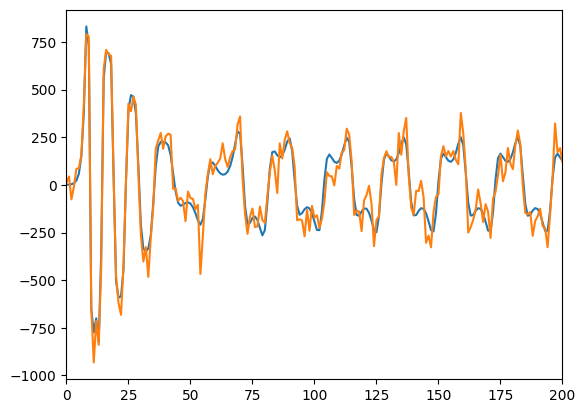

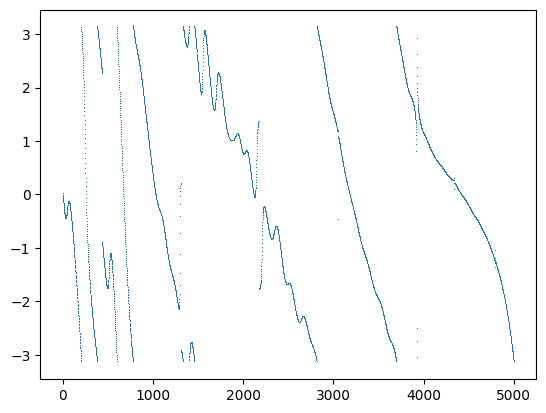

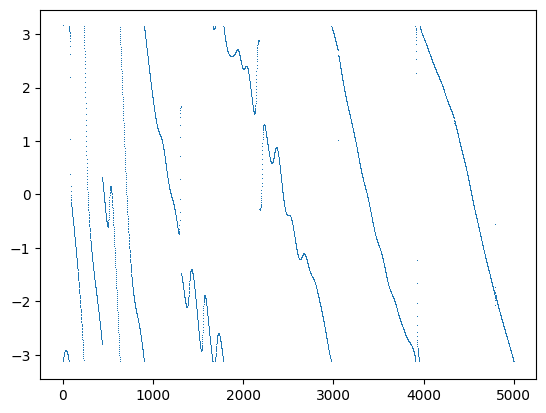

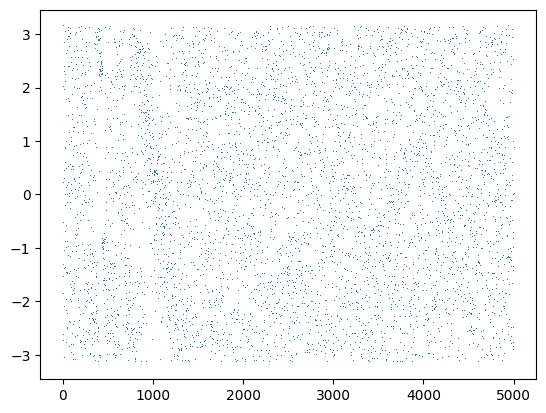

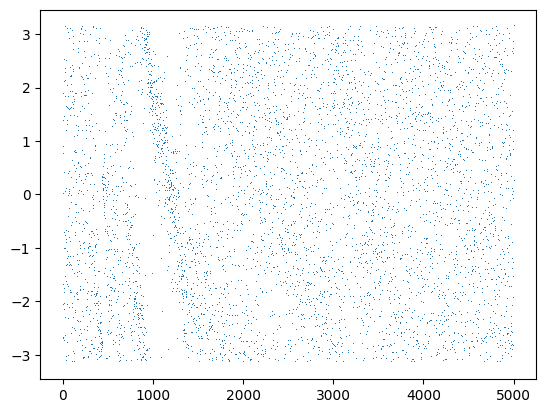

oG: 0.01017194741932892 Ruido:  0.9796918193194654


In [87]:
xs = np.loadtxt('lorenz_x_28.0.txt')
ys = np.loadtxt('lorenz_y_28.0.txt')
xs, ys, zs = lorenz_system(0.0, 1.0, 1.05, sigma=10, rho=1005, beta=8/3, dt=0.01, steps=10000)
# xs, ys = henon_map(1.25, 0.3, 2000)
plt.plot(ys)
xs_ruido = add_white_noise(xs, 7)
ys_ruido = add_white_noise(ys, 7)
xs_discreto = discretizar_y(xs, 10)
ys_discreto = discretizar_y(ys, 10)
# plt.plot(ys_discreto)
plt.plot(ys_ruido)
plt.xlim(0,200)
plt.show()

print('oG:',J_bivariante(xs,ys,5000),'Ruido: ', J_bivariante(xs_ruido,ys_ruido,len(xs_ruido)))

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

corr_J_discret_list = []

def henon_map(a, b, n):
    xs = np.zeros(n)
    ys = np.zeros(n)
    
    xs[0] = 0.1
    ys[0] = 0.1
    
    for i in range(1, n):
        xs[i] = 1 - a * xs[i-1]**2 + ys[i-1]
        ys[i] = b * xs[i-1]
    
    return xs, ys


a_array = np.linspace(1,1.4, 200)
splits = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19, 20, 30, 50,100, 500, 1000,1500,2000,2500, 3000]
# splits = [3500, 4000, 4500, 5000]
for split in splits:
    lyapunov, lyapunov_discreto = [], []
    Js, Js_discreto = [],[]
    for a in a_array: 
        xs, ys = henon_map(a, 0.3, 2000)
        xs_discreto = symbolic_sequence_f(xs,split)
        ys_discreto = symbolic_sequence_f(ys,split)     
        J = J_bivariante(xs,ys,len(xs))
        J_discreto = J_bivariante(xs_discreto,ys_discreto,len(xs_discreto))
        Js.append(J)
        Js_discreto.append(J_discreto)
    
    # Js y Js_discreto ya fue calculado

    data = pd.DataFrame({'Js':Js,
        'Js_discreto':Js_discreto})

    corr_spearman = data.corr(method='spearman')

    corr_J_discret_list.append(corr_spearman.loc['Js','Js_discreto'])

np.savetxt('henon_correlations2.txt', corr_J_discret_list, delimiter=',')


In [12]:
g = np.array([3,5])
gg = np.array([1,2])
print(np.concatenate((g,gg)))

[3 5 1 2]


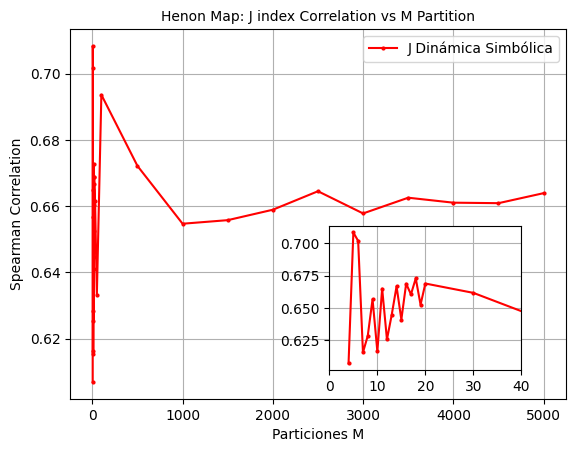

In [13]:
x = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19, 20, 30, 50,100, 500, 1000,1500,2000,2500, 3000, 3500, 4000, 4500, 5000]
corr_J_discret_list = np.concatenate((np.loadtxt('henon_correlations.txt', delimiter=',', unpack=True),np.loadtxt('henon_correlations2.txt', delimiter=',', unpack=True)))

# Crear la gráfica principal
fig, ax = plt.subplots()
ax.plot(x,corr_J_discret_list, label = 'J Dinámica Simbólica',markersize = 4, color = 'red', marker='.', linestyle='-')
# Crear la gráfica de zoom como un inset
ax_inset = fig.add_axes([0.53, 0.17, 0.30, 0.30])  # [left, bottom, width, height] en coordenadas normalizadas
ax_inset.plot(x,corr_J_discret_list, color='red',marker='.', linestyle='-', markersize = 4)
ax_inset.grid()
ax_inset.set_xlim(0, 40)
ax.set_xlabel('Particiones M')
ax.set_ylabel('Spearman Correlation')
ax.grid()
ax.set_title('Henon Map: J index Correlation vs M Partition', fontsize=10)
ax.legend()
plt.show()

# np.savetxt('henon_correlations.txt', np.column_stack((corr_lyapunov_discret_list, corr_J_discret_list)), delimiter=',')
